# Handwritten Digits Classification via SVD

> *Numerical Optimization and Large Scale Linear Algebra*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

Construct an algorithm for classification of handwritten digits. Use a training set, and compute the SVD of each class matrix. Use the first few (5-20) singular vectors as basis and classify unknown test digits according to how well they can be represented in terms of the respective bases (use the relative residual vector in the lest squares problem as a measure).

*Question 1*<br>Tune the algorithm for accuracy of classification.<br>Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors.

*Question *<br>Check if all digits are equally easy or difficult to classify.<br>Also look at some of the difficult ones, and see that in many cases they are very badly written.

*Question 3*<br>Check the singular values of the different classes.<br>Is it motivated to use different numbers of basis vectors for different classes?<br>If so, perform a few experiments to find out if it really pays off to use fewer basis vectors in one or two of the classes.

*Optional*<br>In order to save operations in the test phase, implement a two-stage algorithm.<br>In the first stage compare the unknown digit only to the first singular vector in each class.<br>If for one class the residual is significantly smaller than for the others, classify as that class. Otherwise perform the algorithm above.<br>Is it possible to get as good results for this variant? How frequently is the second stage unnecessary?

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.linalg import svd, norm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score

from tabulate import tabulate
from datetime import datetime

import h5py
import os

import warnings
warnings.filterwarnings("ignore")

## Data

- The data are a subset of the US Postal Service Database
- The file *data.xslx* contains both training and test data
- The sheet *\"azip" ("testzip")* holds the training (test) images as an array of dimension $256 \times 1707$
- The images are vectors of dimension $256$, that have been constructed from $16 \times 16$ images
- The sheet *\"dzip" ("dtest")* holds the digits (numbers) as a vector of dimension $1 \times 1707$

In [2]:
#train data
x_train = pd.read_excel('./Data/data.xlsx', sheet_name='azip', header = None, engine='openpyxl')
y_train = pd.read_excel('./Data/data.xlsx', sheet_name='dzip', header = None, engine='openpyxl')

#test data
x_test = pd.read_excel('./Data/data.xlsx', sheet_name='testzip', header = None, engine='openpyxl')
y_test = pd.read_excel('./Data/data.xlsx', sheet_name='dtest', header = None, engine='openpyxl')

#print shapes
print(f'x_train.shape: {x_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f' x_test.shape: {x_test.shape}')
print(f' y_test.shape: {y_test.shape}')

x_train.shape: (256, 1707)
y_train.shape: (1, 1707)
 x_test.shape: (256, 2007)
 y_test.shape: (1, 2007)


##### *Function to convert and plot an array to an image*

In [3]:
def ImageToArray(digit):
    # Squeeze removes dimensions of size 1 from the shape of an array
    digit_image = np.squeeze(digit)
    
    # Convert to NumPy array
    digit_image = np.asarray(digit_image)
    
    # Normalize pixel values to the range [0, 20]
    digit_image = digit_image - min(digit_image) * np.ones(len(digit_image))
    digit_image = (20 / max(digit_image)) * digit_image
    
    # Reshape the array into a 16x16 image
    digit_image = digit_image.reshape(16, 16)
    
    # Display the image with no x and y-axis ticks
    plt.imshow(digit_image, cmap='gray')
    
    # Remove x and y-axis ticks
    plt.xticks([])
    plt.yticks([])

##### *Plot some random digits*

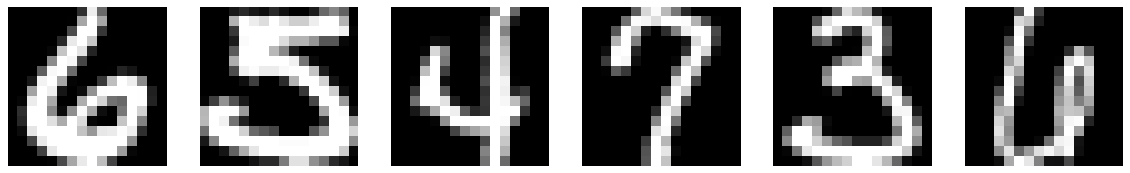

In [4]:
plt.figure(figsize=(20,10))

for i in range(6):
    plt.subplot(1,6,i+1)
    plt.grid(False)
    ImageToArray(x_train.iloc[:,i])

## SVD - Singular Value Decomposition

In linear algebra, **the singular value decomposition (SVD)** is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any $m \times n$ matrix. It is related to the polar decomposition.

Specifically, the singular value decomposition of an $m \times n$ complex matrix $M$ is a factorization of the form $M=UΣV^{*}$, where $U$ is an $m \times m$ complex unitary matrix, $Σ$ is a $m \times n$ rectangular diagonal matrix with non-negative real numbers on the diagonal, and $V$ is an $n \times n$ complex unitary matrix. If $M$ is real, $U$ and $V$ can also be guaranteed to be real orthogonal matrices. In such contexts, the <b>SVD</b> is often denoted $UΣV^{T}$

##### *Define function to perform the SVD*

In [5]:
def get_SVD(x_data, y_data, digit):
    
    #define A matrix
    A =  x_data.loc[:, y_data.loc[0,:] == digit]

    # compute SVD
    U, S, VT = np.linalg.svd(A)
    
    return U, S, VT

#initialize lists
U, S, VT = [], [], []

#execute function for all digits
for d in range(10):
    U.append(get_SVD(x_train,y_train,d)[0])
    S.append(get_SVD(x_train,y_train,d)[1])
    VT.append(get_SVD(x_train,y_train,d)[2])

##### *To get a clearer view of the matrix approximation properties of SVD, we display the first 10 left singular vectors of the digit 6*

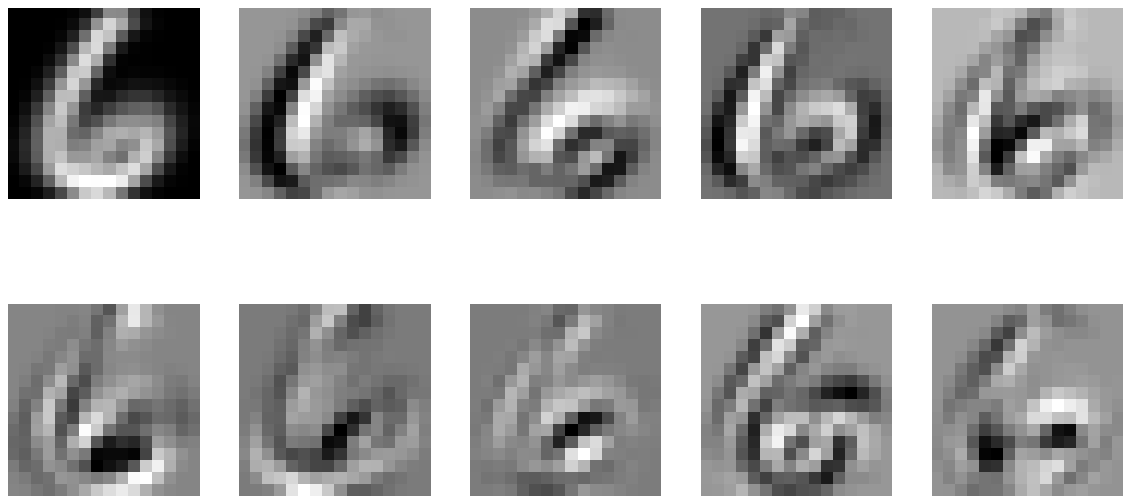

In [6]:
plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.grid(False)
    ImageToArray(U[6][:,i])

## Least Squares Classification

- After applying ***SVD***, the $U$ matrix of each class can be used to construct the classification algorithm
- In particular, we will create a least squares classification algorithm which will use the relative residual vector as a measure
- The residuals will be calculated based on the following function:

$$ \frac {\lVert (I-U_{k}U_{k}^{T})z \rVert_{2}}{\lVert z \rVert_{2}} $$

##### *Define function for the least squares classifier*

In [33]:
def least_squares_classifier(x_data, U, vectors_num):
    
    I = np.eye(x_data.shape[0])
    
    # list to store predictions
    predictions = []
    
    # loop through the images
    for i in range(len(x_data.loc[0,:])):
        
        #  residuals list
        residuals = []
        
        # loop through digits
        for digit in range(10):
            
            #function calculation
            u = U[digit][:,0:vectors_num]
            res = norm(np.dot(I-np.dot(u,u.T),x_data[i]))
            residuals.append(res)
            
        # get the minimum residual
        pred = np.argmin(residuals)
            
        # append the prediction
        predictions.append(pred)
            
    return np.array(predictions)#.reshape((len(predictions),))

## Question 1

- *Tune the algorithm for accuracy of classification.*  
- *Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors.*

##### *Function to find the number of basis vectors*

In [56]:
def define_basis_vectors(x_data, y_data, U, vector_range):
    
    # list to store basic vectors and accuracy
    accuracy = []
    
    #list for predictions
    vector_predictions = []
    
    # loop throug the vector range
    for vector_num in vector_range:
        
        # print progress
        print(f'{vector_num} basis vectors...')
        
        # get predictions
        predictions = least_squares_classifier(x_data, U, vector_num)

        # get accuracy score
        score = accuracy_score(y_data.loc[0,:], predictions)
        
        # append number of basis vectors and accuracy
        accuracy.append([vector_num, score])
        
        # apend predictions
        vector_predictions.append(predictions)
    
    # create a dataframe with the results
    results = pd.DataFrame(accuracy, columns=['Basis_Vectors','Accuracy'])
    
    # print results
    print('\n' + tabulate(results, headers='keys', tablefmt='psql'), end='\n\n')
    
    return results, vector_predictions

In [57]:
start_time = datetime.now()

# execute function
results, vector_predictions = define_basis_vectors(x_test, y_test, U, range(5,21))

end_time = datetime.now()

print(f'Elapsed time: {end_time - start_time}')

5 basis vectors...
6 basis vectors...
7 basis vectors...
8 basis vectors...
9 basis vectors...
10 basis vectors...
11 basis vectors...
12 basis vectors...
13 basis vectors...
14 basis vectors...
15 basis vectors...
16 basis vectors...
17 basis vectors...
18 basis vectors...
19 basis vectors...
20 basis vectors...

+----+-----------------+------------+
|    |   Basis_Vectors |   Accuracy |
|----+-----------------+------------|
|  0 |               5 |   0.90284  |
|  1 |               6 |   0.905331 |
|  2 |               7 |   0.916791 |
|  3 |               8 |   0.920279 |
|  4 |               9 |   0.926258 |
|  5 |              10 |   0.931739 |
|  6 |              11 |   0.932237 |
|  7 |              12 |   0.935725 |
|  8 |              13 |   0.936223 |
|  9 |              14 |   0.939213 |
| 10 |              15 |   0.941206 |
| 11 |              16 |   0.938714 |
| 12 |              17 |   0.939213 |
| 13 |              18 |   0.941704 |
| 14 |              19 |   0.940708 |


- For 18 basis vectors, the model yields the highest accuracy

##### *Results Plot*

Text(0.5, 0, 'Number of Basis Vectors')

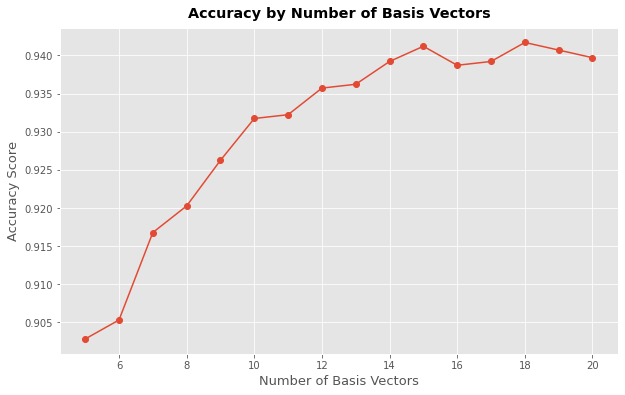

In [58]:
plt.figure(figsize=(10,6))

plt.plot(results.Basis_Vectors, results.Accuracy, marker='o')
plt.title('Accuracy by Number of Basis Vectors', weight="bold" , pad = 10)
plt.ylabel('Accuracy Score' , fontsize = 13)
plt.xlabel('Number of Basis Vectors', fontsize = 13) 

## Question 2

- *Check if all digits are equally easy or difficult to classify.*
- *Also look at some of the difficult ones, and see that in many cases they are very badly written.*

##### *Process*

- For this task, we will use the optimal number of basis vectors (18)
- Then we will obtain the estimates and display some classification metrics to check if there are digits that are easy / hard to classify

##### *Get the estimates and print metrics*

In [59]:
# estimates
y_pred = least_squares_classifier(x_test, U, 18)

In [60]:
def print_metrics(y_data, y_pred):

    #classification report
    class_report = classification_report(y_data.loc[0,:], y_pred)
    
    # confusion matrix
    conf_matrix = confusion_matrix(y_data.loc[0,:], y_pred)
    
    # print results
    print('Classification report using SVD with 18 basis vectors')
    print('='*60)
    print(class_report, end='\n\n')
    print('Confusion matrix using SVD with 18 basis vectors')
    print('='*60)
    print(conf_matrix, end='\n\n')
    
    return

_ = print_metrics(y_test,y_pred)

Classification report using SVD with 18 basis vectors
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       0.97      0.98      0.98       264
           2       0.96      0.90      0.93       198
           3       0.91      0.90      0.91       166
           4       0.91      0.93      0.92       200
           5       0.93      0.88      0.91       160
           6       0.99      0.96      0.97       170
           7       0.95      0.96      0.95       147
           8       0.94      0.92      0.93       166
           9       0.91      0.93      0.92       177

    accuracy                           0.94      2007
   macro avg       0.94      0.94      0.94      2007
weighted avg       0.94      0.94      0.94      2007


Confusion matrix using SVD with 18 basis vectors
[[355   0   2   0   1   0   0   0   0   1]
 [  0 259   0   0   3   0   2   0   0   0]
 [  8   1 178   2   5   0   0   1   3   0]
 [  2   

- As we can see from the F1 score the most difficult digits to classify are 3 and 5
- Below we will investigate whether that is caused by bad handwriting
- To check that we will print the first 10 misclassified examples for these two digits

##### *Digit 3*

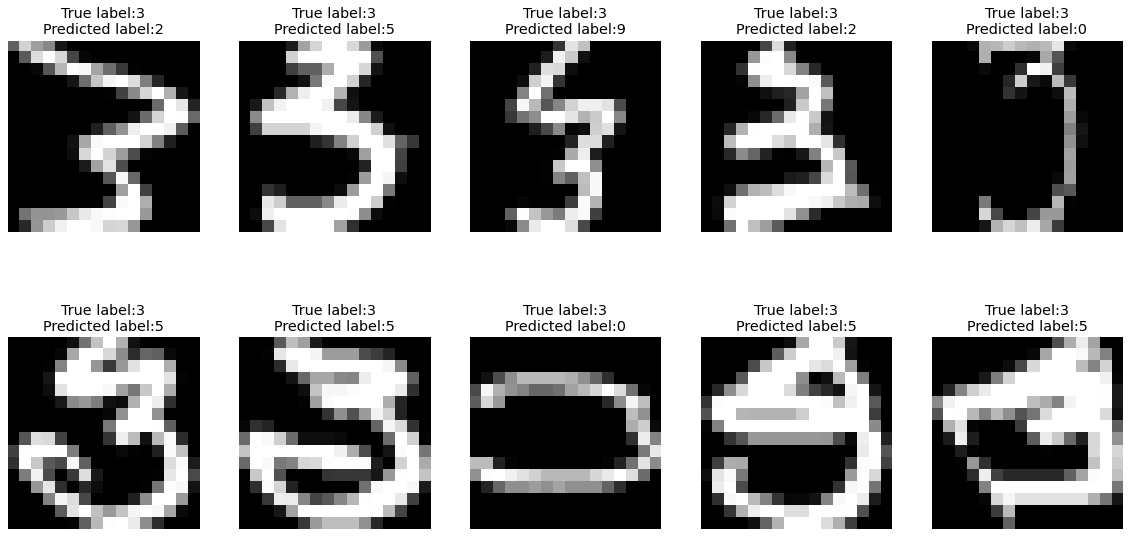

In [61]:
misclassified = np.where((y_test.loc[0,:] != y_pred) & (y_test.loc[0,:] == 3))
plt.figure(figsize=(20,10))

for i in range(2,12):
    misclassified_id=misclassified[0][i]
    image=x_test[misclassified_id]
    
    plt.subplot(2, 5, i-1)
    plt.grid(False)
    ImageToArray(image)
    plt.title("True label:"+str(y_test.loc[0,misclassified_id]) + '\n'+ 
              "Predicted label:"+str(y_pred[misclassified_id]))

##### *Digit 5*

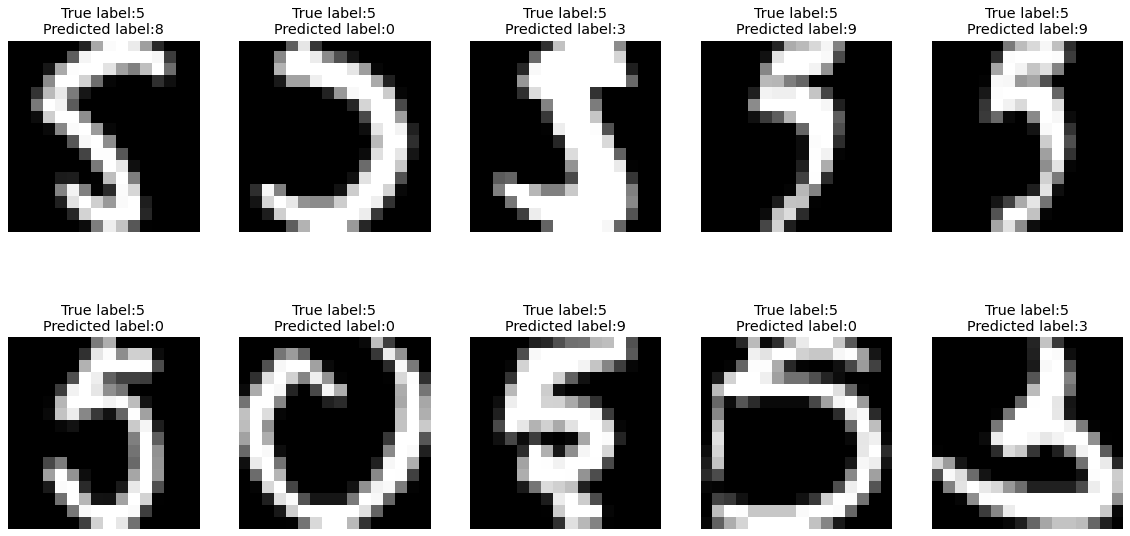

In [62]:
misclassified = np.where((y_test.loc[0,:] != y_pred) & (y_test.loc[0,:] == 5))
plt.figure(figsize=(20,10))

for i in range(2,12):
    misclassified_id=misclassified[0][i]
    image=x_test[misclassified_id]
    
    plt.subplot(2, 5, i-1)
    plt.grid(False)
    ImageToArray(image)
    plt.title("True label:"+str(y_test.loc[0,misclassified_id]) + '\n'+ 
              "Predicted label:"+str(y_pred[misclassified_id]))

- It is evident that there are cases where some of these digits are badly written.
- In some cases, they are so badly written that even a human cannot make a correct distinction

## Question 3

- *Check the singular values of the different classes.*
- *Is it motivated to use different numbers of basis vectors for different classes?*
- *If so, perform a few experiments to find out if it really pays off to use fewer basis vectors in one or two of the classes.*


##### *Process*

- First, we will plot the first 50 singular values to find the digits for which these values decrease the fastest
- Then, we will calculate the f1-score for the different numbers of basis vectors

##### *Plot the singular values*

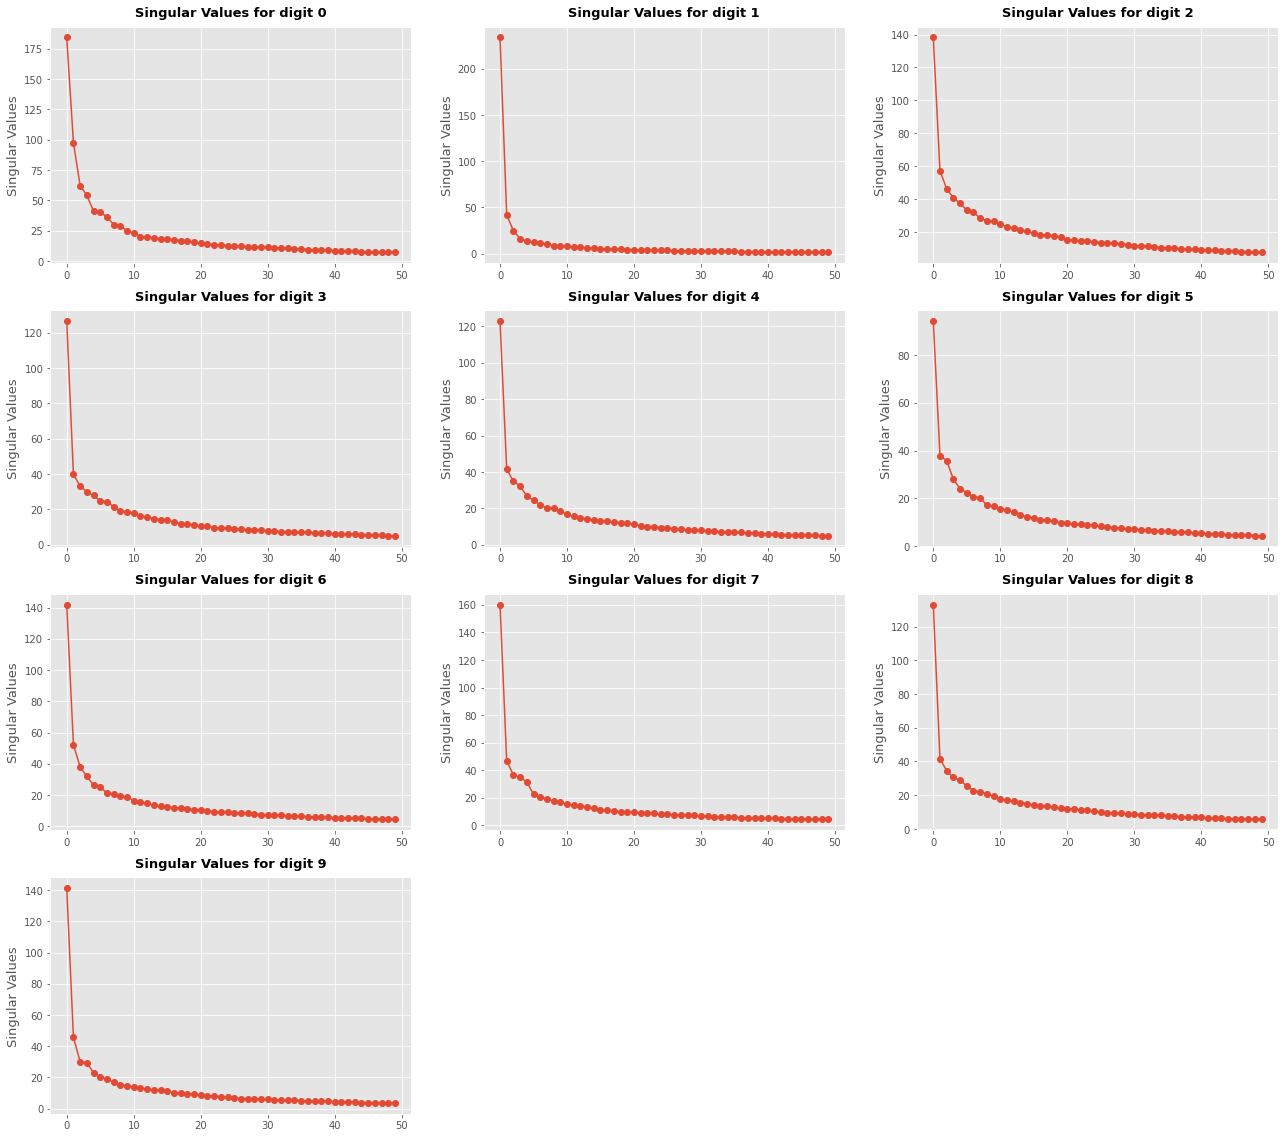

In [63]:
plt.figure(figsize=(22,20))

for i in range(10):
    plt.subplot(4,3,i+1)
    plt.plot(S[i][0:50], marker='o')
    plt.title('Singular Values for digit ' + str(i),fontsize=13,weight="bold",pad=10)
    plt.ylabel('Singular Values' ,fontsize=13)

- As we can see the digit that shows rapidly decreasing singular values is 1

##### *F1-Score*

In [69]:
for i in range(0,14):
    print(f1_score(y_test.loc[0,:] == 1,vector_predictions[i] == 1))

0.9603024574669187
0.9681050656660413
0.962962962962963
0.9611829944547136
0.9648798521256932
0.9684601113172542
0.9701492537313432
0.9719626168224299
0.9737827715355806
0.9774436090225564
0.9774436090225564
0.9774436090225564
0.9774436090225564
0.9773584905660377


- As we can see the F1-Score value is at its highest for k = 14, but the gain in insignificant when compared to k = 18
- Therefore we don't have much to gain by altering the number of basis vectors for each digit class